In [234]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import pdb

import pickle
import adniEnsemble as adens
import tensorflow as tf
from tensorflow import keras
import os
import re

In [2]:
adnifulldf = pd.read_csv("../Dataset/ADNI/adnitable.csv")

In [3]:
# adnifulldf.Gender = adnifulldf.Gender.apply(lambda x: 'M' if x==1 else 'F')
adnifulldf = adnifulldf.fillna(-1)
adnifulldf.DX = adnifulldf.DX.apply(lambda x: 'CN' if x==1 else ('MCI' if x==2 else ('AD' if x==3 else -1)))

In [4]:
adnifulldf.head()

,RID,Gender,Educ,Age,APOE,MMSE,DX,mri_001,mri_002,mri_003,...,fdg_05,amyloid_01,amyloid_02,amyloid_03,amyloid_04,amyloid_05,amyloid_06,csf_01,csf_02,csf_03
0,1,2,18.0,61.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
1,1,2,18.0,61.25,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
2,1,2,18.0,61.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
3,1,2,18.0,62.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
4,1,2,18.0,62.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0


In [5]:
mri_vars = [fieldname for fieldname in adnifulldf.columns if 'mri_' in fieldname]
amyloid_vars = [fieldname for fieldname in adnifulldf.columns if 'amyloid_' in fieldname]
csf_vars = [fieldname for fieldname in adnifulldf.columns if 'csf_' in fieldname]
fdg_vars = [fieldname for fieldname in adnifulldf.columns if 'fdg_' in fieldname]
pet_vars = [fieldname for fieldname in adnifulldf.columns if 'pet_' in fieldname]
factors = ['RID','Gender','Educ','Age','APOE','MMSE','DX']
dx_stages = ['CN', 'AD']

mridf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] != -1), factors+mri_vars]
amyloiddf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["amyloid_01"] != -1), factors+amyloid_vars]
csfdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["csf_01"] != -1), factors+csf_vars]
fdgdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["fdg_01"] != -1), factors+fdg_vars]
petdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["pet_01"] != -1), factors+pet_vars]

In [6]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

3797 1116 1170 1789 1124


## MRI

In [8]:
shuffled_df = mridf.sample(frac=1, random_state=1)
# features = [item for sublist in [['Gender','Educ','Age','APOE'], mri_vars] for item in sublist]
features = mri_vars
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

In [11]:
# specify the model
dlmodel_def = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# perform cross validation to choose number of epochs
max_epochs = 100
validation_fraction = 1/8 # show as a fraction of training data
train_acc, val_acc, epoch_arr = trainDeepLearningModelCV(dlmodel_def, training_X, training_Y, 
                                                         validation_fraction, max_epochs)

Training CV number: 0
Training CV number: 1
Training CV number: 2
Training CV number: 3
Training CV number: 4
Training CV number: 5
Training CV number: 6
Training CV number: 7


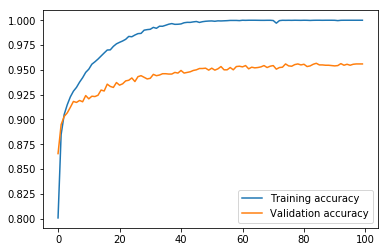

In [12]:
plt.plot(epoch_arr, np.mean(train_acc, axis=0), label='Training accuracy')
plt.plot(epoch_arr, np.mean(val_acc, axis=0), label='Validation accuracy')
plt.legend()
plt.show()

In [13]:
dlmodel = dlmodel_def
dlmodel.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs_from_cv = 40 # pick this from the plot of training and validation performance
train_mean_list = np.mean(training_X, axis=0)
train_std_list = np.std(training_X, axis=0)
dlmodel_history = dlmodel.fit((training_X - train_mean_list)/train_std_list, training_Y, epochs=epochs_from_cv, verbose=1)

Epoch 1/40
3038/3038 [==============================] - 0s 105us/step - loss: 0.4111 - acc: 0.8180
Epoch 2/40
3038/3038 [==============================] - 0s 28us/step - loss: 0.2953 - acc: 0.8904
Epoch 3/40
3038/3038 [==============================] - 0s 32us/step - loss: 0.2562 - acc: 0.9085
Epoch 4/40
3038/3038 [==============================] - 0s 32us/step - loss: 0.2275 - acc: 0.9217
Epoch 5/40
3038/3038 [==============================] - 0s 37us/step - loss: 0.2117 - acc: 0.9253
Epoch 6/40
3038/3038 [==============================] - 0s 33us/step - loss: 0.1957 - acc: 0.9282
Epoch 7/40
3038/3038 [==============================] - 0s 39us/step - loss: 0.1792 - acc: 0.9361
Epoch 8/40
3038/3038 [==============================] - 0s 36us/step - loss: 0.1689 - acc: 0.9421
Epoch 9/40
3038/3038 [==============================] - 0s 32us/step - loss: 0.1596 - acc: 0.9440
Epoch 10/40
3038/3038 [==============================] - 0s 32us/step - loss: 0.1467 - acc: 0.9526
Epoch 11/40
3038/3

In [14]:
print("Test accuracy is: %.2f%%" % (100*dlmodel.evaluate((testing_X-train_mean_list)/train_std_list, testing_Y)[1]))

759/759 [==============================] - 0s 147us/step
Test accuracy is: 96.18%


In [61]:
def trainDeepLearningModelCV(model, data_X, data_Y, val_frac, train_epochs):
    num_cv = int(np.round(1/val_frac))
    val_perf = np.zeros((num_cv, train_epochs))
    train_perf = np.zeros((num_cv, train_epochs))
    
    for cvn in range(0, num_cv):
        print("Training CV number: %d" % (cvn))
        # split training and validation data
        train_X_ns, val_X_ns, train_Y, val_Y = train_test_split(data_X, data_Y, 
                                                          train_size=1-val_frac, test_size=val_frac, shuffle=True)
        # standardize validation and training data using training data
        mean_list_train = np.mean(train_X_ns, axis=0)
        std_list_train = np.std(train_X_ns, axis=0)
        train_X = (train_X_ns - mean_list_train)/std_list_train
        val_X = (val_X_ns - mean_list_train)/std_list_train

        # create model instance and compile it
        temp_model = keras.Sequential.from_config(model.get_config())
        temp_model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
        # train model
        temp_model.fit(train_X, train_Y, 
                       epochs=train_epochs, 
                       validation_data=(val_X, val_Y),
                       verbose=0)
        epoch_array = temp_model.history.epoch
        val_perf[cvn,:] = temp_model.history.history['val_acc']
        train_perf[cvn,:] = temp_model.history.history['acc']
    
    return train_perf, val_perf, epoch_array

In [177]:
dirpath = '../Dataset/ProcessedFiles/'
modality = 'csf_'
modality_files = [fname for fname in os.listdir(dirpath) if modality in fname]
perfdict = dict()

for file in modality_files:
    keyname = re.sub(modality+'|_cv.pckl','', file)
    if 'logistic_regression' in keyname:
        keyname = re.sub('logistic_regression','LR',keyname)
    elif 'random_forest' in keyname:
        keyname = re.sub('random_forest','RF',keyname)
    elif 'svm' in keyname:
        keyname = re.sub('svm','SVM', keyname)
    perfdict[keyname] = [gridout['test_score']['accuracy'] for gridout in pickle.load(open(dirpath+file,'rb'))]

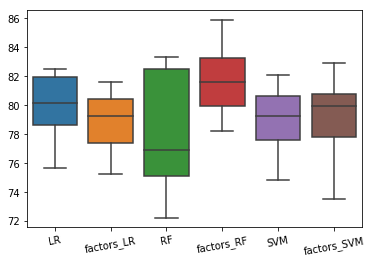

In [178]:
sns.boxplot(data=pd.DataFrame(perfdict), order=['LR','factors_LR','RF','factors_RF','SVM','factors_SVM'])
plt.xticks(rotation=10)
plt.show()

In [121]:
pd.DataFrame(perfdict).mean()

factors_LR     92.758621
factors_RF     89.588859
factors_SVM    95.106101
LR             91.193634
RF             88.673740
SVM            94.509284
dtype: float64

In [137]:
# analysis of best parameters
csfbestclf_list = pickle.load(open('../Dataset/ProcessedFiles/csf_factors_random_forest_cv.pckl','rb'))
print([item_params['n_estimators'] for item_params in [item['model'].get_params() for item in csfbestclf_list]])

[13, 17, 19, 14, 12, 19, 13, 19, 18, 14]


In [110]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

3797 1116 1170 1789 1124


In [72]:
adnidf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] ==-1)].copy()

In [78]:
100*len(adnidf[(adnidf["pet_01"] != -1)])/len(petdf)

93.23843416370107

Keep all subjects who do not have any MRI for testing. Patients who have atleast MRI have 76% patients with Amyloid, 94% patients with CSF, 90% patients with FDG and 93% patients with PET. Using 80% of the patients with all MRI for training and 20% of it for testing.

In [270]:
# prepare training and test data
# all rows that are AD/CN, Education present and at least the MRI scans
adnidf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] !=-1)].copy()
adnidf["DX_bin"] = np.where(adnidf["DX"] == "CN", 0, 1) # CN: 0, AD: 1

training_df, testing2_df = train_test_split(adnidf, test_size=0.2, shuffle=True)

# all rows that are AD/CN, Education present and no MRI scans
testing1_df = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] == -1)].copy()
testing1_df["DX_bin"] = np.where(testing1_df["DX"] == "CN", 0, 1) # CN: 0, AD: 1

# combine test data
testing_df = pd.concat([testing1_df, testing2_df], sort=False)

In [271]:
gs_num_cv = 10
csfout = modalityModelTrainWrapper('random_forest', 'csf', training_df, gs_num_cv)

arbit = testing_df.loc[(testing_df['csf_01']!=-1), csf_columns]
csfout['model'].score((arbit[csfout['features']]-csfout['train_mod_mean'])/csfout['train_mod_std'], arbit['DX_bin'])

Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:    7.0s finished
/home/ksaboo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [262]:
gs_num_cv = 10
amyloidout = modalityModelTrainWrapper('logistic_regression', 'amyloid', training_df, gs_num_cv)

amyloid_columns = [item for sublist in [['Gender','Age','Educ','APOE', 'DX_bin'], amyloid_vars] for item in sublist]
arbit = testing_df.loc[(testing_df['amyloid_01']!=-1), amyloid_columns]
amyloidout['model'].score((arbit[amyloidout['features']]-amyloidout['train_modality_mean'])/amyloidout['train_modality_std'], arbit['DX_bin'])

/media/UIUC Courses/Sem 5/CS598JP/Project/Code/adniEnsemble.py:22: RuntimeWarning: invalid value encountered in long_scalars
  specificity = 100*confmat[0,0]/(confmat[0,0]+confmat[0,1]) # TN/(TN+FP)
/home/ksaboo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8514150943396226

In [266]:
amyloidout['model'].coef_

array([[-0.51555619,  0.05008728, -0.34983019,  0.30440661, -0.14134136,
        -0.26482642, -0.71819857,  0.13972011,  2.60644087, -0.2558909 ]])

In [268]:
# train each modality - use the method which had best on average performance for each modality as evaluated in previous experiment
def modalityModelTrainWrapper(classifier_name, modality_name, train_df, num_cv):
    # auxiliary information required in DF
    aux_info = ['Gender','Age','Educ','APOE','DX_bin']
    factors = ['Gender','Age','Educ','APOE']
    
    # grid search parameters
    if classifier_name == 'random_forest':
        param_grid = {'n_estimators':np.arange(10,21,dtype=int), 'max_depth':np.arange(3,7,dtype=int)}
    elif classifier_name == 'logistic_regression':
        param_grid = 20
    else:
        print('Classifier not found')
        return 0
    
    # prepare data
    modality_vars = [fieldname for fieldname in train_df.columns if modality_name in fieldname]
    modality_columns = [item for sublist in [aux_info, modality_vars] for item in sublist]
    modality_features = [item for sublist in [factors, modality_vars] for item in sublist]
    
    train_modalitydf = train_df.loc[train_df[modality_name+'_01'] !=-1, modality_columns]
    
    # standardize training data
    train_modality_mean = train_modalitydf[modality_features].mean()
    train_modality_std = train_modalitydf[modality_features].std()
    train_X_zs = (train_modalitydf[modality_features]-train_modality_mean)/train_modality_std
    
    dummy_test_X = train_X_zs.iloc[0:2]
    dummy_test_Y = train_modalitydf.iloc[0:2].DX_bin
    
    # perform parameter sweep for classifier and train model
    gridout = adens.gridSearchWrapper(classifier_name, param_grid, num_cv, train_X_zs, 
                                          train_modalitydf['DX_bin'], dummy_test_X, dummy_test_Y)

    return {'model':gridout['model'], 'features':modality_features,
            'train_mod_mean':train_modality_mean, 'train_mod_std':train_modality_std}
